<p style="text-align:center"> 
    <a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/" target="_blank"> 
    <img src="../assets/logo.png" width="200" alt="Flavio Aguirre Logo"> 
    </a>
</p>

<h1 align="center"><font size="7"><strong>📉 ByeBye Predictor</strong></font></h1>
<br>
<hr>

## TELCO Feature Selection

Feature selection is critical because it:

* Reduces the risk of overfitting.

* Improves model interpretability.

* Reduces training and deployment time.

* Maximizes predictive performance (f1 score, recall, etc.).

``Objective:``
* Build a transparent and modular process, applying filter, wrapper, and embedded methods, with advanced techniques that enable robust selection of the best features.
* Optimize the pipeline to detect churners (high recall), as it is more costly to lose a customer than to fake a no-churn scenario.
* Leave the pipeline ready to integrate it with textual sentiment analysis data in the next stage.

In [1]:
import joblib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, RFE
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
)

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Visual style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

<hr>

In the previous lab (notebook 7), we had processed the new variables to match the dataset's scale, but we hadn't saved it. Let's process it again and save the dataset so we don't lose the reference in this step, where we'll manipulate the dataset again.

In [3]:
df = pd.read_csv('../data/processed/telco-feature-engineering.csv')
print(f"\nDataset loaded with shape: {df.shape}")


Dataset loaded with shape: (7032, 37)


In [4]:
# Features to select
X = df.drop(columns='churn')

# The two new numeric columns to scale
new_num_cols = ['avg_monthly_spend', 'num_services']

# All other columns
other_cols = X.columns.difference(new_num_cols).tolist()

# Preprocessor: scale only new numerics
preprocessor = ColumnTransformer([
    ('scale_new', StandardScaler(), new_num_cols),     # Scale only new ones
    ('keep_others', 'passthrough', other_cols)         # Leave the rest the same
])

print("\nPreprocessor created successfully.")


Preprocessor created successfully.


In [5]:
# Apply preprocessor to the dataset
X_transformed = preprocessor.fit_transform(X)

# Save the dataset
scaled_df = pd.DataFrame(X_transformed, columns=new_num_cols + other_cols)
scaled_df['churn'] = df['churn'].values
scaled_df.to_csv('../data/processed/telco-feature-engineering-scaled.csv', index=False)
print("\nDataset saved after scaling the new features.")


Dataset saved after scaling the new features.


In [6]:
# Load the scaled dataset
df = pd.read_csv('../data/processed/telco-feature-engineering-scaled.csv')
print(f"\nScaled dataset loaded with shape: {df.shape}")


Scaled dataset loaded with shape: (7032, 37)


<br>

<hr>

Before selecting, you need to understand the relationship of each feature with the target variable ``churn`` (We had seen this when we performed the EDA but did not modify anything. This time, we will act on this analysis for a robust selection of the labels).

We separate by data type:

We must remember that our dataset no longer contains categorical labels, only numeric and Boolean ones, so the analysis will be a little easier.

In [7]:
# Separate numeric and boolean data (although they are basically the same data type)
num_features = ['tenure', 'monthlycharges', 'totalcharges', 'avg_monthly_spend', 'num_services']
bool_features = df.drop(num_features + ['churn'], axis=1).columns.tolist()

We analyze the numerical variables using the ``Pearson correlation``

In [8]:
# Numerical correlation with churn
corr = df[num_features + ['churn']].corr()['churn'].sort_values(ascending=False)
print(f"Correlation with churn (numerical):\n {corr}")

Correlation with churn (numerical):
 churn                1.000000
monthlycharges       0.192858
avg_monthly_spend    0.010232
num_services        -0.067459
totalcharges        -0.199484
tenure              -0.354049
Name: churn, dtype: float64


With this we try to find out if there is collinearity between variables (we could even apply this to Boolean variables since they are also basically numeric).

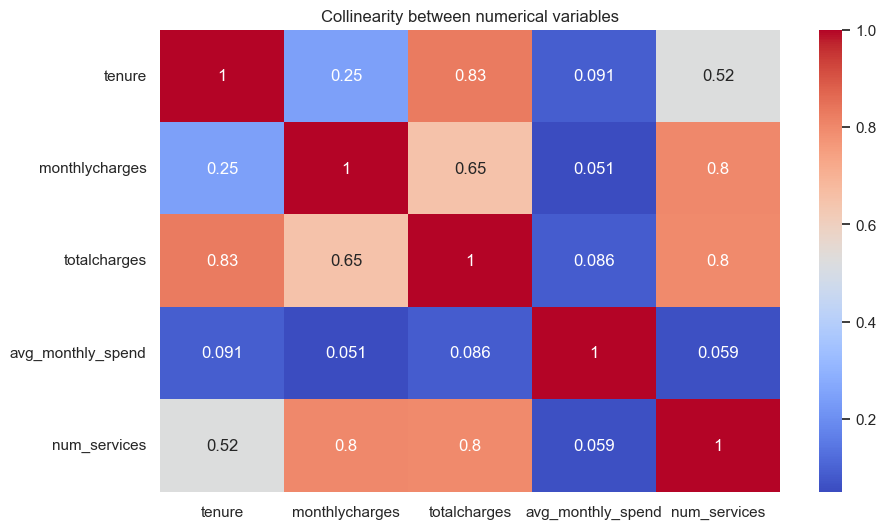

In [9]:
# Visualize collinearity between numerics
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm')
plt.title("Collinearity between numerical variables")
plt.show()

Now with boolean variables we use ``Mutual Information``

In [10]:
# Mutual Information for our Boolean variables
# (generally used for categorical variables since if you want)
mi_scores = mutual_info_classif(df[bool_features], df['churn'], discrete_features=True, random_state=42)
mi_results = pd.Series(mi_scores, index=bool_features).sort_values(ascending=False)
print("Mutual Information:\n", mi_results)

Mutual Information:
 contract_two_year                       0.060289
internetservice_fiber_optic             0.047646
paymentmethod_electronic_check          0.043800
internetservice_no                      0.031274
onlinebackup_no_internet_service        0.031274
onlinesecurity_no_internet_service      0.031274
deviceprotection_no_internet_service    0.031274
streamingmovies_no_internet_service     0.031274
streamingtv_no_internet_service         0.031274
techsupport_no_internet_service         0.031274
high_spender                            0.021263
paperlessbilling_yes                    0.019119
contract_one_year                       0.018145
onlinesecurity_yes                      0.015891
techsupport_yes                         0.014614
dependents_yes                          0.014270
partner_yes                             0.011383
seniorcitizen_yes                       0.010533
paymentmethod_credit_card_automatic     0.009890
has_fiber_contract                      0.007310

At first glance, we can see variables with:
* High positive correlation with churn (e.g., ``contract_two_year``, ``internetservice_fiber_optic``).
* Variables that are almost independent of churn (candidates for elimination).
* Variables that are collinear with each other (only one could be left).

### Distribution of positive churns

In [11]:
# We check the proportions of the Boolean labels
df[bool_features] = df[bool_features].astype(int) # We make sure they are 0 and 1
bool_summary = df[bool_features].mean().sort_values(ascending=False)
print("Proportion of '1' in Booleans:\n", bool_summary)

Proportion of '1' in Booleans:
 is_new_customer                         1.000000
phoneservice_yes                        0.903299
paperlessbilling_yes                    0.592719
high_spender                            0.557594
gender_male                             0.504693
partner_yes                             0.482509
internetservice_fiber_optic             0.440273
multiplelines_yes                       0.421928
streamingmovies_yes                     0.388367
streamingtv_yes                         0.384386
onlinebackup_yes                        0.344852
deviceprotection_yes                    0.343857
paymentmethod_electronic_check          0.336320
dependents_yes                          0.298493
techsupport_yes                         0.290102
onlinesecurity_yes                      0.286547
contract_two_year                       0.239619
paymentmethod_mailed_check              0.228100
paymentmethod_credit_card_automatic     0.216297
internetservice_no                   

Here:

* Boolean variables with proportions close to 0% or 100% → candidates for elimination.

* Numerical variables with collinearity > 0.85 → we could eliminate one from each pair.

<br>

### ``FILTER Method`` for preselection

Why? We filter out irrelevant variables before entering complex models.

In this case, we only apply ``VarianceThreshold()`` because:

* For Boolean labels: we detect constants.

* For Numeric labels: we don't need ANOVA or Chi² because we will evaluate the importance of features directly in the models.

In [12]:
X = df.drop(columns='churn')
y = df['churn']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [15]:
# We remove features with variance ~0 using VarianceThreshold on the
# training set to avoid data leakage
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X_train)
selected_features_var = df.drop('churn', axis=1).columns[var_thresh.get_support()]
print(f"\nFeatures after Variance Threshold:\n {selected_features_var.tolist()}")
print(f"\nNumber of selected features: {len(selected_features_var)}")
print(f"\nNumber of original features: {len(X.columns)}")
print(f"\nRemoved features: {(set(X.columns) - set(selected_features_var))}")


Features after Variance Threshold:
 ['avg_monthly_spend', 'num_services', 'contract_one_year', 'contract_two_year', 'dependents_yes', 'deviceprotection_no_internet_service', 'deviceprotection_yes', 'gender_male', 'has_fiber_contract', 'high_spender', 'internetservice_fiber_optic', 'internetservice_no', 'monthlycharges', 'multiplelines_no_phone_service', 'multiplelines_yes', 'onlinebackup_no_internet_service', 'onlinebackup_yes', 'onlinesecurity_no_internet_service', 'onlinesecurity_yes', 'paperlessbilling_yes', 'partner_yes', 'paymentmethod_credit_card_automatic', 'paymentmethod_electronic_check', 'paymentmethod_mailed_check', 'phoneservice_yes', 'seniorcitizen_yes', 'streamingmovies_no_internet_service', 'streamingmovies_yes', 'streamingtv_no_internet_service', 'streamingtv_yes', 'techsupport_no_internet_service', 'techsupport_yes', 'tenure', 'totalcharges']

Number of selected features: 34

Number of original features: 36

Removed features: {'is_new_customer', 'is_loyal_customer'}


We observed that we went from 36 to 34 features.

We compared the models with this new subset.

``It doesn't seem necessary to use PCA (Principal Component Analysis) here because we have ~35 variables and there is no extreme “noise.”``

<br>

### Importance of features

Let's first look at the importance of the features obtained from ``selected_features_var`` as a function of ``churn`` for each model (remember that we only want to get an idea of how the attributes of the new subset affect the models, and that's why we use all the data):

In [16]:
X_final = df[selected_features_var]
y_final = df['churn']

* ``Model 1: Logistic regression``

In [17]:
# Logistic Regression with L1
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
logreg.fit(X_final, y_final)
lasso_coeffs = pd.Series(logreg.coef_[0], index=selected_features_var)
important_lasso = lasso_coeffs[lasso_coeffs != 0].sort_values(ascending=False)

In [18]:
print(f"\nFeature importance (Logistic Regression L1):\n {important_lasso}")


Feature importance (Logistic Regression L1):
 internetservice_fiber_optic            0.717115
totalcharges                           0.620798
monthlycharges                         0.346343
paperlessbilling_yes                   0.342007
paymentmethod_electronic_check         0.299230
seniorcitizen_yes                      0.214629
multiplelines_yes                      0.204294
streamingmovies_yes                    0.116528
streamingtv_yes                        0.104550
avg_monthly_spend                      0.064011
internetservice_no                    -0.004361
has_fiber_contract                    -0.004574
gender_male                           -0.021768
paymentmethod_mailed_check            -0.068144
paymentmethod_credit_card_automatic   -0.083195
deviceprotection_yes                  -0.089300
dependents_yes                        -0.144058
onlinebackup_yes                      -0.212123
high_spender                          -0.346033
techsupport_yes                       -0.

* ``Model 2: Decision tree``

In [19]:
# Decision Tree Feature Importance
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_final, y_final)
tree_importances = pd.Series(
    tree.feature_importances_, index=selected_features_var).sort_values(ascending=False)

In [20]:
print(f"\nFeature importance (Decision Tree):\n {tree_importances}")


Feature importance (Decision Tree):
 tenure                                  0.179318
totalcharges                            0.151807
monthlycharges                          0.135523
avg_monthly_spend                       0.135358
internetservice_fiber_optic             0.107369
gender_male                             0.028776
has_fiber_contract                      0.025997
seniorcitizen_yes                       0.019424
dependents_yes                          0.019242
paymentmethod_electronic_check          0.018192
paperlessbilling_yes                    0.017188
techsupport_yes                         0.016498
onlinesecurity_yes                      0.015976
onlinebackup_yes                        0.014654
paymentmethod_mailed_check              0.013704
partner_yes                             0.012818
multiplelines_yes                       0.012438
num_services                            0.010978
deviceprotection_yes                    0.010924
paymentmethod_credit_card_autom

* ``Model 3: XGBoost``

In [21]:
# XGBoost Feature Importance
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_final, y_final)
xgb_importances = pd.Series(
    xgb.feature_importances_, index=selected_features_var).sort_values(ascending=False)

In [22]:
print(f"\nFeature importance (XGBoost):\n {xgb_importances}")


Feature importance (XGBoost):
 internetservice_fiber_optic             0.443094
contract_two_year                       0.143155
deviceprotection_no_internet_service    0.076381
contract_one_year                       0.060112
has_fiber_contract                      0.049295
tenure                                  0.022885
streamingmovies_yes                     0.019716
multiplelines_no_phone_service          0.014913
paymentmethod_electronic_check          0.013229
high_spender                            0.012202
techsupport_yes                         0.011579
multiplelines_yes                       0.011261
onlinesecurity_yes                      0.010646
paperlessbilling_yes                    0.010170
seniorcitizen_yes                       0.009453
onlinebackup_yes                        0.009345
streamingtv_yes                         0.008697
totalcharges                            0.008621
dependents_yes                          0.008157
paymentmethod_mailed_check           

We see that the models that best exploit the features are LogisticRegression and XGBoost.

<br>

### ``EMBEDDED Methods`` Using Our 3 Candidate Models

In this stage, we'll use ``Recursive Feature Elimination`` (RFE) for each model separately. We'll also use ``Stratified K-Fold`` to avoid overfitting.

We'll do this using the subset obtained from VarianceThreshold. We'll evaluate the models' performance with these 34 labels, and then with all of them.

We train the new models:

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
# Models
logreg = LogisticRegression(max_iter=1000, random_state=42)
tree = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [25]:
# List of models and names
models = [
    (logreg, "LogisticRegression"),
    (tree, "DecisionTreeClassifier"),
    (xgb, "XGBoostClassifier")
]

In [26]:
# Dictionary to store the selected features
selected_features_dict = {}

# Number of features to select
n_features_to_select = len(selected_features_var.tolist())

Here we separate the data so that the model doesn't see all of them and then have a blank sample to compare the metrics.

In [28]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final,
    y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

In [29]:
for model, model_name in models:
    print("")
    print(f"\n=== {model_name} ===")

    # Pipeline with RFE
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    pipeline = Pipeline([
        ('feature_selection', rfe),
        ('classifier', model)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train_final, y_train_final, cv=cv, scoring='f1')

    print(f"\n{model_name} F1 average: {scores.mean():.4f}")

    # Train the pipeline on all of X_train to get selected features
    pipeline.fit(X_train_final, y_train_final)

    # Save the selected features
    selected_features = X_train_final.columns[pipeline.named_steps['feature_selection'].support_]
    selected_features_dict[model_name] = set(selected_features)

    # We show features
    print(f"Selected Features ({len(selected_features)}):")
    print(selected_features.tolist())

# We compare the selected features between modelsos
print("")
print("\n=== Comparison between models ===")
for model1, features1 in selected_features_dict.items():
    for model2, features2 in selected_features_dict.items():
        if model1 != model2:
            common_features = features1.intersection(features2)
            print(f"{model1} ∩ {model2} → {len(common_features)} common features")
            if len(common_features) > 0:
                print(f"Common features: {sorted(list(common_features))}")



=== LogisticRegression ===

LogisticRegression F1 average: 0.5972
Selected Features (34):
['avg_monthly_spend', 'num_services', 'contract_one_year', 'contract_two_year', 'dependents_yes', 'deviceprotection_no_internet_service', 'deviceprotection_yes', 'gender_male', 'has_fiber_contract', 'high_spender', 'internetservice_fiber_optic', 'internetservice_no', 'monthlycharges', 'multiplelines_no_phone_service', 'multiplelines_yes', 'onlinebackup_no_internet_service', 'onlinebackup_yes', 'onlinesecurity_no_internet_service', 'onlinesecurity_yes', 'paperlessbilling_yes', 'partner_yes', 'paymentmethod_credit_card_automatic', 'paymentmethod_electronic_check', 'paymentmethod_mailed_check', 'phoneservice_yes', 'seniorcitizen_yes', 'streamingmovies_no_internet_service', 'streamingmovies_yes', 'streamingtv_no_internet_service', 'streamingtv_yes', 'techsupport_no_internet_service', 'techsupport_yes', 'tenure', 'totalcharges']


=== DecisionTreeClassifier ===

DecisionTreeClassifier F1 average: 0.5

What do we see?

| Model | #Features | Average F1 |
| ------------------ | --------- | ----------- |
| LogisticRegression | 34 | **0.5972** |
| DecisionTree | 34 | **0.5004** |
| XGBoost | 34 | **0.5705** |

All three models selected the same 34 features. This confirms that:

* There are no variables we should immediately remove.

* Feature reduction is likely not contributing much here.

* LogisticRegression is the strongest in F1 (0.59), while DecisionTree drops to 0.50.

* This suggests that LogisticRegression is making good use of the encoded features, and that the trees may need hyperparameter tuning or pruning of irrelevant features.

* The scores are not "bad," but they are not in the range of a "maximized" model either.

* This tells us: it's time to refine and optimize, not just select features.

Finally, we'll test the subset without using ``VarianceThreshold``, that is, with the 36 features we started this lab with. We do this to ensure we don't lose any information, since this method, ``VarianceThreshold``, for the sake of redundancy, doesn't take into account the relationship with the target variable (the 'churn' label).

In [30]:
# Dictionary to store selected features
selected_features_dict = {}

# Number of features to select
n_features_to_select = 36

In [31]:
for model, model_name in models:
    print("")
    print(f"\n=== {model_name} ===")

    # Pipeline with RFE
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    pipeline = Pipeline([
        ('feature_selection', rfe),
        ('classifier', model)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

    print(f"\n{model_name} F1 average: {scores.mean():.4f}")

    # Train the pipeline on all of X_train to get selected features
    pipeline.fit(X_train, y_train)

    # Save the selected features
    selected_features = X_train.columns[pipeline.named_steps['feature_selection'].support_]
    selected_features_dict[model_name] = set(selected_features)

    # We show features
    print(f"Selected Features ({len(selected_features)}):")
    print(selected_features.tolist())

# We compare the selected features between modelsos
print("")
print("\n=== Comparison between models ===")
for model1, features1 in selected_features_dict.items():
    for model2, features2 in selected_features_dict.items():
        if model1 != model2:
            common_features = features1.intersection(features2)
            print(f"{model1} ∩ {model2} → {len(common_features)} common features")
            if len(common_features) > 0:
                print(f"Common features: {sorted(list(common_features))}")



=== LogisticRegression ===

LogisticRegression F1 average: 0.5966
Selected Features (36):
['avg_monthly_spend', 'num_services', 'contract_one_year', 'contract_two_year', 'dependents_yes', 'deviceprotection_no_internet_service', 'deviceprotection_yes', 'gender_male', 'has_fiber_contract', 'high_spender', 'internetservice_fiber_optic', 'internetservice_no', 'is_loyal_customer', 'is_new_customer', 'monthlycharges', 'multiplelines_no_phone_service', 'multiplelines_yes', 'onlinebackup_no_internet_service', 'onlinebackup_yes', 'onlinesecurity_no_internet_service', 'onlinesecurity_yes', 'paperlessbilling_yes', 'partner_yes', 'paymentmethod_credit_card_automatic', 'paymentmethod_electronic_check', 'paymentmethod_mailed_check', 'phoneservice_yes', 'seniorcitizen_yes', 'streamingmovies_no_internet_service', 'streamingmovies_yes', 'streamingtv_no_internet_service', 'streamingtv_yes', 'techsupport_no_internet_service', 'techsupport_yes', 'tenure', 'totalcharges']


=== DecisionTreeClassifier ===

We compare

| Model | #Features | Average F1 |
| ------------------ | --------- | ----------- |
| LogisticRegression | 34 | **0.5972** |
| DecisionTree | 34 | **0.5004** |
| XGBoost | 34 | **0.5705** |

<br>

| Model | #Features | Average F1 |
| ------------------ | --------- | ----------- |
| LogisticRegression | 36 | **0.5966** |
| DecisionTree | 36 | **0.4932** |
| XGBoost | 36 | **0.5705** |

The evaluation metrics for the models with the 34 features show a very slight improvement in the Logistic Regression and Decision Tree models, while XGBoost remains unchanged.

Again, all three models selected the same features.

<br>

***Unified dataset or model?***

We're going to use a unified dataset with all 34 features because:

* All three models selected exactly the same columns → there's no evidence that separating subsets provides any advantage now.

* A unified dataset is simpler to maintain and facilitates subsequent integration for analyzing comments obtained from Reddit.

``If after hyperparameter optimization (GridSearch) we see that a model is lagging, we then evaluate a separate subset.``

We create the pipelines and evaluate

* ``Model 1: Logistic regression``

In [37]:
# Define pipeline
lr_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# Hyperparameter Grid
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Grid search
lr_grid = GridSearchCV(
    lr_pipeline, 
    lr_param_grid,
    cv=cv, 
    scoring='f1', 
    n_jobs=-1
)
lr_grid.fit(X_train_final, y_train_final)

print(f"Best parameters (LogisticRegression): {lr_grid.best_params_}")
print(f"Best f1: {lr_grid.best_score_}")

Best parameters (LogisticRegression): {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Best f1: 0.62891031272715


* ``Model 2: Decision tree``

In [36]:
tree_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

tree_param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

tree_grid = GridSearchCV(
    tree_pipeline, 
    tree_param_grid,
    cv=cv, 
    scoring='f1', 
    n_jobs=-1
)
tree_grid.fit(X_train_final, y_train_final)

print(f"Best parameters (DecisionTree): {tree_grid.best_params_}")
print(f"Best f1: {tree_grid.best_score_}")

Best parameters (DecisionTree): {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best f1: 0.612014395595703


* ``Model 3: XGBoost``

In [38]:
# Calculate ratio for scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'))
])

xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__n_estimators': [100, 200]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid,
    cv=cv, 
    scoring='f1', 
    n_jobs=-1
)
xgb_grid.fit(X_train_final, y_train_final)

print(f"Best parameters (XGBoost): {xgb_grid.best_params_}")
print(f"Best f1: {xgb_grid.best_score_}")

Best parameters (XGBoost): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best f1: 0.614513518030754


In [97]:
# Best model and metrics
print(f"\nLogisticRegression best f1: {lr_grid.best_score_}")
print(f"Best parameters: {lr_grid.best_params_}")

print(f"\nDecisionTree best f1: {tree_grid.best_score_}")
print(f"Best parameters: {tree_grid.best_params_}")

print(f"\nXGBoost best f1: {xgb_grid.best_score_}")
print(f"Best parameters: {xgb_grid.best_params_}\n")


LogisticRegression best f1: 0.62891031272715
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}

DecisionTree best f1: 0.612014395595703
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 2}

XGBoost best f1: 0.614513518030754
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}



### We evaluate with our test set

In [39]:
def evaluate_model(model, X_test_final, y_test_final):
    y_pred = model.predict(X_test_final)

    # Some versions of SVM don't have predict_proba enabled by default
    try:
        y_proba = model.predict_proba(X_test_final)[:, 1]
        auc = roc_auc_score(y_test_final, y_proba)
    except:
        y_proba = None
        auc = "N/A"

    print(f"\nModel: {model.steps[-1][1].__class__.__name__}-{model.__class__.__name__} with feature selection")
    print(f"Accuracy: {accuracy_score(y_test_final, y_pred)}")
    print(f"Precision: {precision_score(y_test_final, y_pred)}")
    print(f"Recall: {recall_score(y_test_final, y_pred)}")
    print(f"F1 Score: {f1_score(y_test_final, y_pred)}")
    print(f"AUC-ROC: {auc}") 
    print("-" * 40) 
    # Confusion Matrix
    cm = confusion_matrix(y_test_final, y_pred) 
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"]) 
    disp.plot(cmap="Blues") 
    plt.title(f"Confusion Matrix - {model.steps[-1][1].__class__.__name__}-{model.__class__.__name__} with feature selection") 
    # plt.savefig(f"../reports/figures/telco-model-optimization/confusion_matrix_{model.steps[-1][1].__class__.__name__}-{model.__class__.__name__}_feature_selection.png") 
    plt.show()


Model: LogisticRegression-Pipeline with feature selection
Accuracy: 0.7427149964463398
Precision: 0.5111524163568774
Recall: 0.7352941176470589
F1 Score: 0.6030701754385965
AUC-ROC: 0.8299887146621389
----------------------------------------


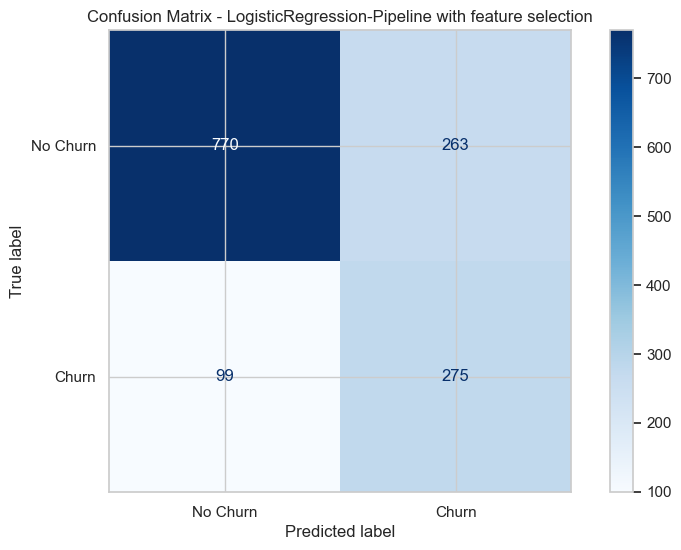


Model: DecisionTreeClassifier-Pipeline with feature selection
Accuracy: 0.7235252309879175
Precision: 0.48743718592964824
Recall: 0.7780748663101604
F1 Score: 0.5993820803295572
AUC-ROC: 0.8109058813175891
----------------------------------------


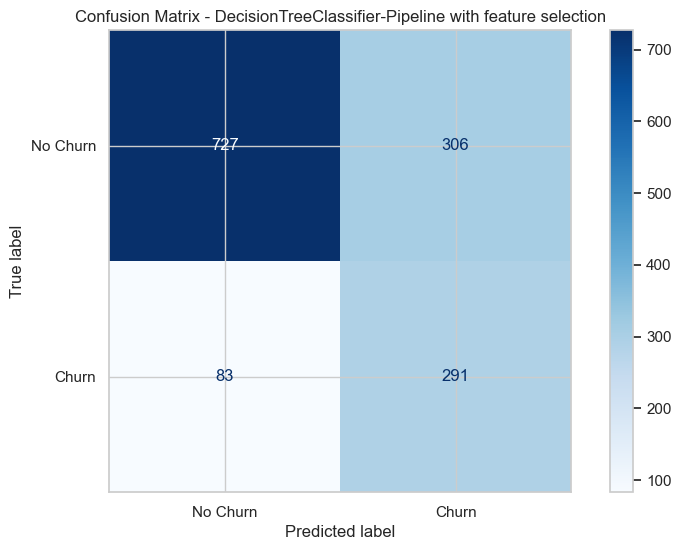


Model: XGBClassifier-Pipeline with feature selection
Accuracy: 0.7078891257995735
Precision: 0.4704
Recall: 0.786096256684492
F1 Score: 0.5885885885885885
AUC-ROC: 0.8162573574708419
----------------------------------------


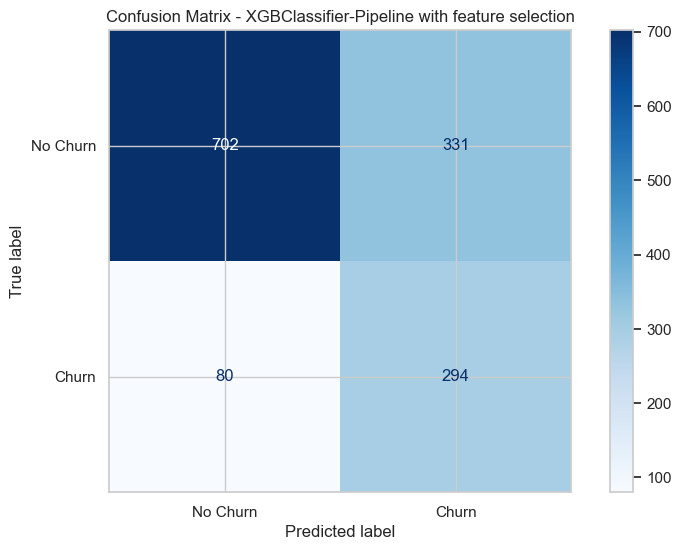

In [40]:
models = [lr_grid.best_estimator_, tree_grid.best_estimator_, xgb_grid.best_estimator_]
for model in models:
    evaluate_model(model, X_test_final, y_test_final)

### Model Ensemble (Stacking)

An ensemble is a technique that combines several base models to create a more robust and accurate model.
Let's see if applying this technique can improve the metrics obtained. So far, LogisticRegression wins with an f1 of 0.60, but in terms of recall, this metric drops, and XGBoost wins with 0.78. This means that out of 100 users predicted to abandon the service (churn = 1), 78 actually did so.

Let's focus on these two models, so we'll run two ensembles: one with LogisticRegression as the meta-model and the other with XGBoost, to compare them later.

We use the best parameters we already know to design the meta-models.

In [41]:
meta_model_lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=42,
    class_weight='balanced'
)

In [42]:
meta_model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
)

🔄 Training StackingClassifier with LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear') as meta-model...
🔄 Calibrating probabilities...

🔎 Searching for optimal threshold for LogisticRegression...

🔎 Searching for optimal threshold for DecisionTree...

🔎 Searching for optimal threshold for XGBoost...

🔎 Searching for optimal threshold for Stacking (Calibrated)...

🏆 Top 3 models (sorted by F1):
                   Model  Optimal Threshold  Accuracy  Precision  Recall  \
0     LogisticRegression              0.630    0.7939     0.6014  0.6658   
1  Stacking (Calibrated)              0.393    0.7910     0.5957  0.6658   
2                XGBoost              0.682    0.7676     0.5503  0.6872   
3           DecisionTree              0.645    0.7662     0.5492  0.6711   

   F1 Score  AUC-ROC  
0    0.6320   0.8300  
1    0.6288   0.8352  
2    0.6112   0.8163  
3    0.6041   0.8109  


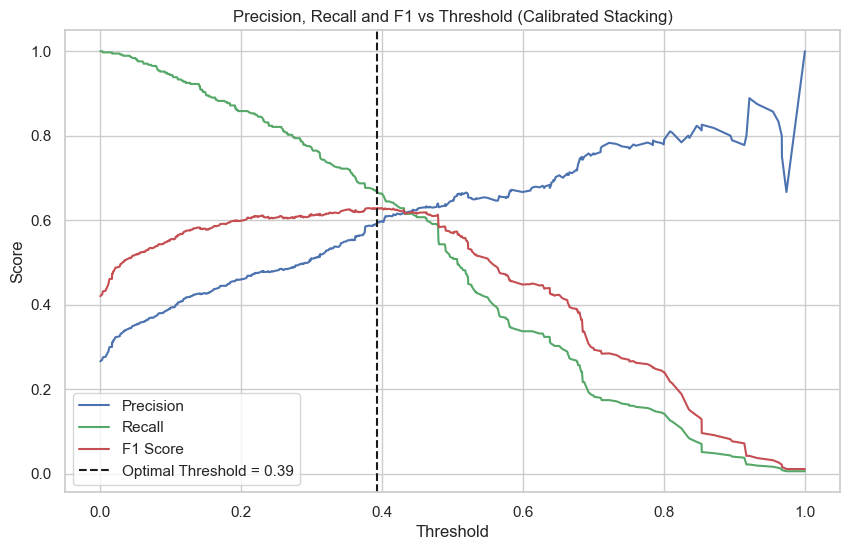

c:\Users\Pc\Desktop\github\byebye_predictor\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


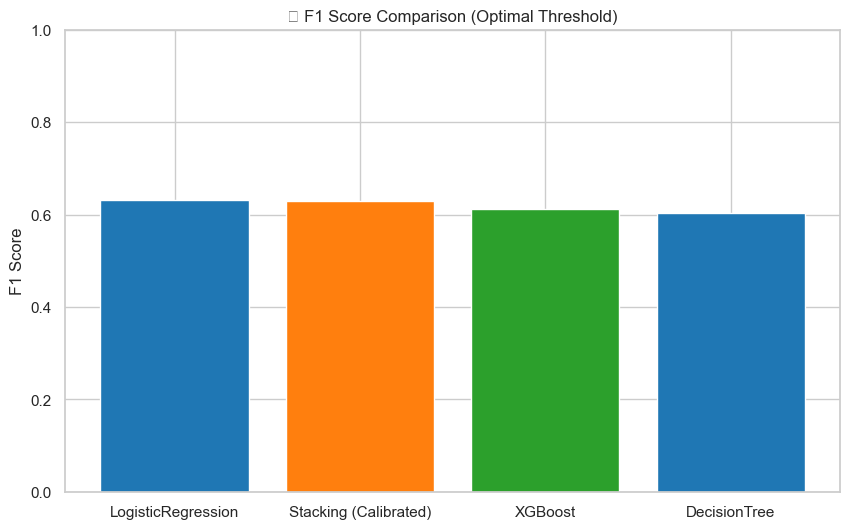


🥇 Winning model: LogisticRegression with F1 = 0.632
👉 Optimal Threshold: 0.63


In [43]:
# ====================================================================
# 1. Building the Ensemble (Stacking)
# ========================================================================

stacking_clf = StackingClassifier(
    estimators=[
        ('logreg', lr_grid.best_estimator_), # Optimized LogisticRegression
        ('tree', tree_grid.best_estimator_), # Optimized DecisionTree
        ('xgb', xgb_grid.best_estimator_) # Optimized XGBoost
    ],
    final_estimator= meta_model_lr, # Meta-model is also LogisticRegression optimized
    cv=cv,
    n_jobs=-1
)

print(f"🔄 Training StackingClassifier with {meta_model_lr} as meta-model...")
stacking_clf.fit(X_train_final, y_train_final)

# =====================================================================
# 2. Calibrating Probabilities (for Reliable Outputs)
# ====================================================================
calibrated_stacking = CalibratedClassifierCV(
    estimator=stacking_clf, cv=cv, method='isotonic'
)

print("🔄 Calibrating probabilities...")
calibrated_stacking.fit(X_train_final, y_train_final)

# ================================================================================
# 3. Functions for evaluation
# ==============================================================
def find_optimal_threshold(model, X, y): 
    """ 
    Find the threshold that maximizes F1 for a given model 
    """ 
    probas = model.predict_proba(X)[:, 1] 
    precisions, recalls, thresholds = precision_recall_curve(y, probas) 
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) 
    best_idx = np.argmax(f1_scores) 
    return { 
        "Optimal Threshold": thresholds[best_idx], 
        "Precision": precisions[best_idx], 
        "Recall": recalls[best_idx], 
        "F1 Score": f1_scores[best_idx], 
        "AUC-ROC": roc_auc_score(y, probas), 
        "Probas": probas, 
        "Thresholds": thresholds, 
        "Precisions": precisions, 
        "Recalls": recalls, 
        "F1 Scores": f1_scores 
    }

def evaluate_model(model, X, y, threshold): 
    """ 
    Calculate key metrics at a specific threshold 
    """ 
    probas = model.predict_proba(X)[:, 1] 
    preds = (probas >= threshold).astype(int) 
    acc = accuracy_score(y, preds) 
    prec = precision_score(y, preds, zero_division=0) 
    rec = recall_score(y, preds, zero_division=0) 
    f1 = f1_score(y, preds, zero_division=0)
    auc = roc_auc_score(y, probas)
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC-ROC": auc
    }

# =====================================================================
# 4. Comparing models and optimal thresholds
# ============================================================================
# Models to compare
models = {
    "LogisticRegression": lr_grid.best_estimator_, 
    "DecisionTree": tree_grid.best_estimator_, 
    "XGBoost": xgb_grid.best_estimator_, 
    "Stacking (Calibrated)": calibrated_stacking
}

results = []

for name, model in models.items(): 
    print(f"\n🔎 Searching for optimal threshold for {name}...") 
    metrics = find_optimal_threshold(model, X_test_final, y_test_final) 
    threshold_opt = metrics["Optimal Threshold"] 
    eval_metrics = evaluate_model(model, X_test_final, y_test_final, threshold_opt) 

    results.append({ 
    "Model": name, 
    "Optimal Threshold": round(threshold_opt, 3), 
    **{k: round(v, 4) for k, v in eval_metrics.items()} 
    })

# 🏆 Top 3 models ranked by F1
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
print("\n🏆 Top 3 models (sorted by F1):")
print(results_df)

# ================================================================
# 5. Views
# ==============================================================

# 📈 Precision, Recall and F1 vs Threshold for stacking
stacking_metrics = find_optimal_threshold(calibrated_stacking, X_test_final, y_test_final)
plt.figure(figsize=(10,6))
plt.plot(stacking_metrics["Thresholds"], stacking_metrics["Precisions"][:-1], label="Precision", color='b')
plt.plot(stacking_metrics["Thresholds"], stacking_metrics["Recalls"][:-1], label="Recall", color='g')
plt.plot(stacking_metrics["Thresholds"], stacking_metrics["F1 Scores"][:-1], label="F1 Score", color='r')
plt.axvline(stacking_metrics["Optimal Threshold"], linestyle='--', color='k', label=f"Optimal Threshold = {stacking_metrics['Optimal Threshold']:.2f}")
plt.title("Precision, Recall and F1 vs Threshold (Calibrated Stacking)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

# F1 Comparison Barplot
plt.bar(results_df["Model"], results_df["F1 Score"], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("🏆 F1 Score Comparison (Optimal Threshold)")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()

# ==================================================================
# 6. Winner Announcement
# =======================================================
print(f"\n🥇 Winning model: {results_df.loc[0, 'Model']} with F1 = {results_df.loc[0, 'F1 Score']}")
print(f"👉 Optimal Threshold: {results_df.loc[0, 'Optimal Threshold']}")

Now again but xgboost

🔄 Training StackingClassifier with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...) as meta-model...
🔄 Calibrating probabilities...

🔎 Searching for optimal threshold for LogisticRegression...

🔎 Searching for optimal threshold for DecisionTree...

🔎 Searching for optimal t

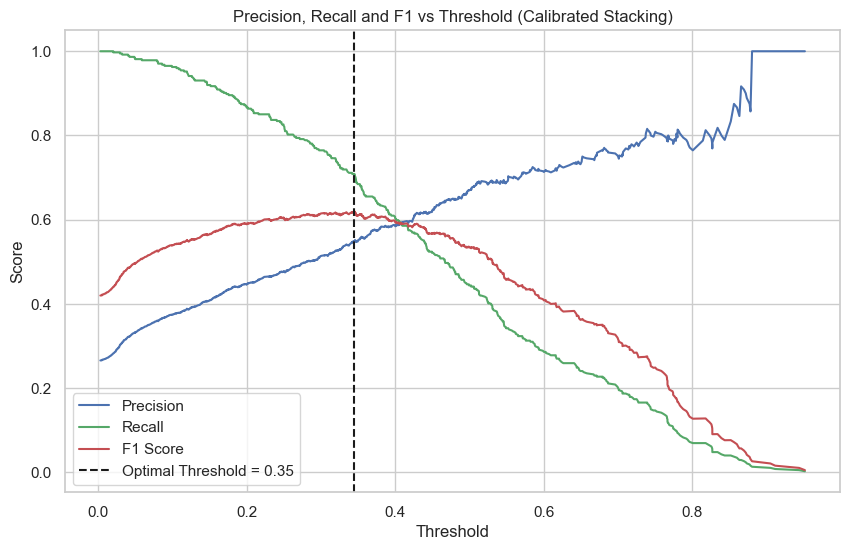

c:\Users\Pc\Desktop\github\byebye_predictor\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


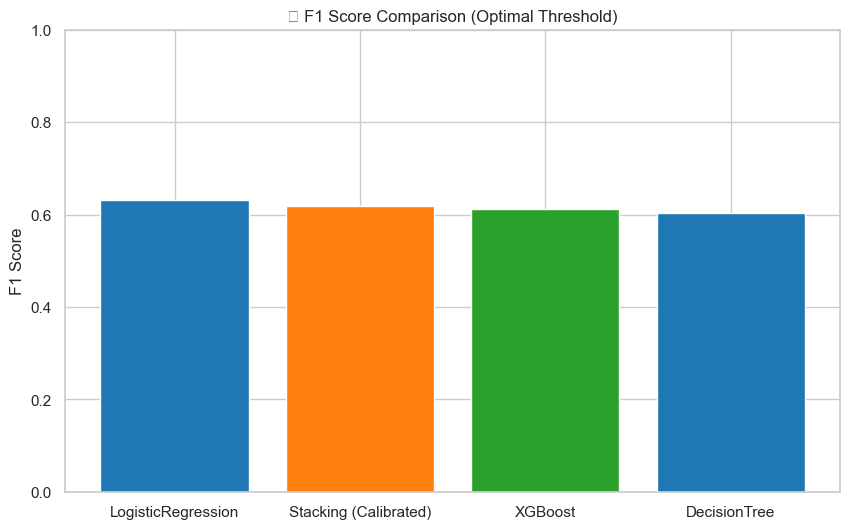


🥇 Winning model: LogisticRegression with F1 = 0.632
👉 Optimal Threshold: 0.63


In [44]:
# ====================================================================
# 1. Building the Ensemble (Stacking)
# ========================================================================

stacking_clf = StackingClassifier(
    estimators=[
        ('logreg', lr_grid.best_estimator_), # Optimized LogisticRegression
        ('tree', tree_grid.best_estimator_), # Optimized DecisionTree
        ('xgb', xgb_grid.best_estimator_) # Optimized XGBoost
    ],
    final_estimator= meta_model_xgb, # Meta-model is also XGBoost optimized
    cv=cv,
    n_jobs=-1
)

print(f"🔄 Training StackingClassifier with {meta_model_xgb} as meta-model...")
stacking_clf.fit(X_train_final, y_train_final)

# =====================================================================
# 2. Calibrating Probabilities (for Reliable Outputs)
# ====================================================================
calibrated_stacking = CalibratedClassifierCV(
    estimator=stacking_clf, cv=cv, method='isotonic'
)

print("🔄 Calibrating probabilities...")
calibrated_stacking.fit(X_train_final, y_train_final)

# ================================================================================
# 3. Functions for evaluation
# ==============================================================
def find_optimal_threshold(model, X, y): 
    """ 
    Find the threshold that maximizes F1 for a given model 
    """ 
    probas = model.predict_proba(X)[:, 1] 
    precisions, recalls, thresholds = precision_recall_curve(y, probas) 
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) 
    best_idx = np.argmax(f1_scores) 
    return { 
        "Optimal Threshold": thresholds[best_idx], 
        "Precision": precisions[best_idx], 
        "Recall": recalls[best_idx], 
        "F1 Score": f1_scores[best_idx], 
        "AUC-ROC": roc_auc_score(y, probas), 
        "Probas": probas, 
        "Thresholds": thresholds, 
        "Precisions": precisions, 
        "Recalls": recalls, 
        "F1 Scores": f1_scores 
    }

def evaluate_model(model, X, y, threshold): 
    """ 
    Calculate key metrics at a specific threshold 
    """ 
    probas = model.predict_proba(X)[:, 1] 
    preds = (probas >= threshold).astype(int) 
    acc = accuracy_score(y, preds) 
    prec = precision_score(y, preds, zero_division=0) 
    rec = recall_score(y, preds, zero_division=0) 
    f1 = f1_score(y, preds, zero_division=0)
    auc = roc_auc_score(y, probas)
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC-ROC": auc
    }

# =====================================================================
# 4. Comparing models and optimal thresholds
# ============================================================================
# Models to compare
models = {
    "LogisticRegression": lr_grid.best_estimator_, 
    "DecisionTree": tree_grid.best_estimator_, 
    "XGBoost": xgb_grid.best_estimator_, 
    "Stacking (Calibrated)": calibrated_stacking
}

results = []

for name, model in models.items(): 
    print(f"\n🔎 Searching for optimal threshold for {name}...") 
    metrics = find_optimal_threshold(model, X_test_final, y_test_final) 
    threshold_opt = metrics["Optimal Threshold"] 
    eval_metrics = evaluate_model(model, X_test_final, y_test_final, threshold_opt) 

    results.append({ 
        "Model": name, 
        "Optimal Threshold": round(threshold_opt, 3), 
        **{k: round(v, 4) for k, v in eval_metrics.items()} 
    })

# 🏆 Top 3 models ranked by F1
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
print("\n🏆 Top 3 models (sorted by F1):")
print(results_df)

# ================================================================
# 5. Views
# ==============================================================

# 📈 Precision, Recall and F1 vs Threshold for stacking
stacking_metrics = find_optimal_threshold(calibrated_stacking, X_test_final, y_test_final)
plt.figure(figsize=(10,6))
plt.plot(stacking_metrics["Thresholds"], stacking_metrics["Precisions"][:-1], label="Precision", color='b')
plt.plot(stacking_metrics["Thresholds"], stacking_metrics["Recalls"][:-1], label="Recall", color='g')
plt.plot(stacking_metrics["Thresholds"], stacking_metrics["F1 Scores"][:-1], label="F1 Score", color='r')
plt.axvline(stacking_metrics["Optimal Threshold"], linestyle='--', color='k', label=f"Optimal Threshold = {stacking_metrics['Optimal Threshold']:.2f}")
plt.title("Precision, Recall and F1 vs Threshold (Calibrated Stacking)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

# F1 Comparison Barplot
plt.bar(results_df["Model"], results_df["F1 Score"], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("🏆 F1 Score Comparison (Optimal Threshold)")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()

# ==================================================================
# 6. Winner Announcement
# =======================================================
print(f"\n🥇 Winning model: {results_df.loc[0, 'Model']} with F1 = {results_df.loc[0, 'F1 Score']}")
print(f"👉 Optimal Threshold: {results_df.loc[0, 'Optimal Threshold']}")

<br>

<hr>

## Author

<a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/">**Flavio Aguirre**</a>
<br>
<a href="https://coursera.org/share/e27ae5af81b56f99a2aa85289b7cdd04">***Data Scientist***</a>